# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.644562,False,0.566714
1,-0.816872,True,5.296541
2,0.868957,False,-0.122583
3,0.811932,False,1.801955
4,0.091480,True,5.019614
...,...,...,...
995,1.364107,False,1.907257
996,0.929869,False,-1.077934
997,0.431969,False,0.677709
998,0.053581,False,-0.013652


<Axes: xlabel='v0'>

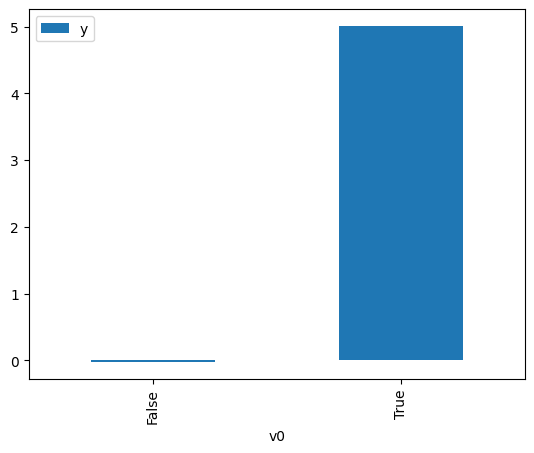

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

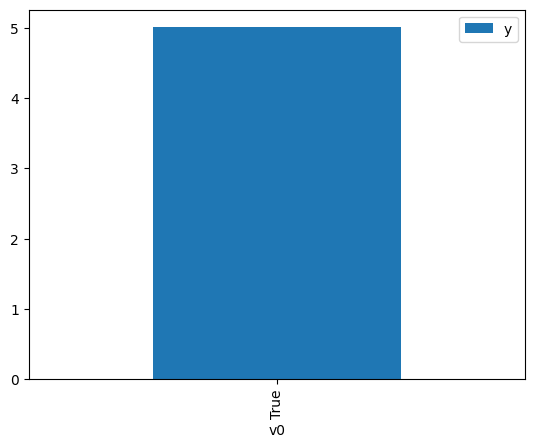

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.785782,False,-0.271061,0.463098,2.159370
1,1.358409,False,0.591507,0.444809,2.248158
2,-0.123085,False,-0.165316,0.492312,2.031232
3,1.027232,False,0.146091,0.455371,2.196010
4,-0.922382,False,-0.308894,0.518054,1.930301
...,...,...,...,...,...
995,0.569748,False,0.534572,0.470027,2.127539
996,0.602925,False,1.283997,0.468962,2.132370
997,-0.688877,False,-0.616507,0.510538,1.958719
998,0.884624,False,-0.471937,0.459933,2.174232


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.622322,True,5.103120,0.531661,1.880899
1,1.349541,True,6.416128,0.554909,1.802097
2,1.597363,True,6.048707,0.562782,1.776886
3,-1.059765,True,4.469923,0.477527,2.094121
4,0.119964,True,4.738400,0.515514,1.939812
...,...,...,...,...,...
995,-0.152479,True,4.939441,0.506741,1.973394
996,0.651252,True,7.249233,0.532589,1.877621
997,1.638505,True,4.318765,0.564086,1.772778
998,-0.376144,True,5.830552,0.499536,2.001858


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.933
Model:                            OLS   Adj. R-squared (uncentered):              0.933
Method:                 Least Squares   F-statistic:                              6972.
Date:                Thu, 20 Jul 2023   Prob (F-statistic):                        0.00
Time:                        13:35:47   Log-Likelihood:                         -1418.2
No. Observations:                1000   AIC:                                      2840.
Df Residuals:                     998   BIC:                                      2850.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9003      0.032     28.033      0.000       0.837       0.963
x2             5.0047      0.044    113.050      0.000       4.918       5.092
==============================================================================
Omnibus:                        1.679   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                1.634
Skew:                          -0.016   Prob(JB):                        0.442
Kurtosis:                       3.195   Cond. No.                         1.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""